# Problem Set 3
## Fundamentals of Simulation Methods

#### Author:    Elias Olofsson

#### Version information:
        2020-11-25: v.1.0. First public release. 


In [1]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import time

## Exercise 2 - Integration of a stiff equation (8 pts)
#### Part (a) - Implementation with constant step size $\Delta t$

In [2]:
kB = 1.38 * 10**-23     # Boltzmann's constant      (J/K)
nH = 10**6              # Number density hydrogen   (m^-3)
lambda0 = 10**-35       # Cooling rate constant     (J*m^3*s^-1)
T0 = 20000              # Temperature threshold     (K)
alpha = 10.0            # Function parameter        (1)
beta = -0.5             # Function parameter        (1)

def lambda_f(T):
    if T <= T0:
        return lambda0*(T/T0)**alpha
    else:
        return lambda0*(T/T0)**beta

def f(T):
    return -2/(3*kB)*nH*lambda_f(T)

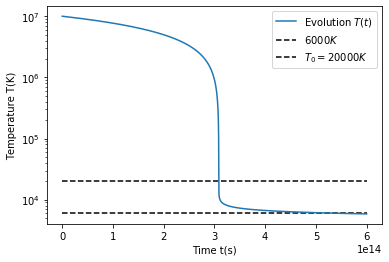

In [6]:
T_init = 10**7      # Initial temperature   (K)
dt = 10**10         # Stepsize              (s)
N = 6*10**4         # Total simulated steps (1)

T = np.zeros(N)
T[0] = T_init

for i in range(N-1):
    k1 = f(T[i])
    k2 = f(T[i]+k1*dt)
    T[i+1] = T[i] + dt*(k1+k2)/2

t = np.arange(N)*dt
plt.plot(t,T,label='Evolution $T(t)$')
plt.yscale('log')
plt.xlabel('Time t(s)')
plt.ylabel('Temperature T(K)')
plt.hlines(6000,min(t),max(t),linestyles='dashed', label='$6000K$')
plt.hlines(T0,min(t),max(t),linestyles='dashed', label='$T_0 = 20000K$')
plt.legend()

# Saving T and t for comparison in part (c)
T_constdt = T
t_constdt = t

#### Part (b) - Unstable simulation with large $\Delta t$

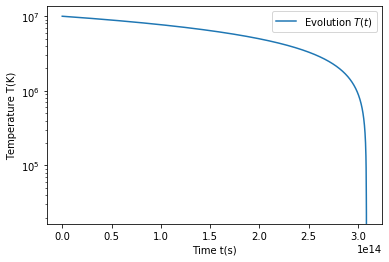

In [4]:
T_init = 10**7      # Initial temperature   (K)
dt = 10**11         # Stepsize              (s)
N = 6*10**4         # Total simulated steps (1)

T = np.zeros(N)
T[0] = T_init

for i in range(N-1):
    k1 = f(T[i])
    k2 = f(T[i]+k1*dt)
    T[i+1] = T[i] + dt*(k1+k2)/2

t = np.arange(N)*dt
plt.plot(t,T,label='Evolution $T(t)$')
plt.yscale('log')
plt.xlabel('Time t(s)')
plt.ylabel('Temperature T(K)')
plt.legend()

#### Part (c) - Adaptive step size implementation

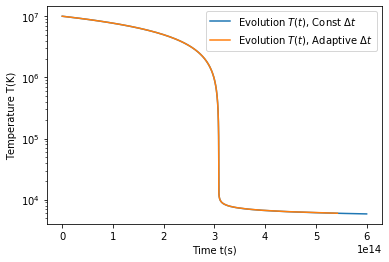

In [5]:
T_init = 10**7      # Initial temperature           (K)
N = 79              # Total simulated steps         (1)

dt = 10**14         # Initial Stepsize              (s)
errmax_loc = 50     # Local error bound in T        (K)
errmin_loc = 5      # Local lower error bound in T  (K)

T = np.zeros(N)
t = np.zeros(N)

T[0] = T_init
T_tmp = -1 

for i in range(N-1):
    T_i = T[i]
    t_i = t[i]
    flag = True
    while flag:
        # Take a step of size dt => y_A
        if T_tmp == -1: # Utlilize middle step y_B if it already has been calulated
            k1 = f(T_i)
            k2 = f(T_i+k1*dt)
            T_nextA = T_i + dt*(k1+k2)/2
        else:
            T_nextA = T_tmp

        # Take two steps of stepsize dt/2 => y_B
        k1 = f(T_i)
        k2 = f(T_i+k1*dt/2)
        T_tmp = T_i + dt/2*(k1+k2)/2

        k1 = f(T_tmp)
        k2 = f(T_tmp+k1*dt/2)
        T_nextB = T_tmp + dt/2*(k1+k2)/2

        # Error estimate y = |y_A - y_B|
        err_est = abs(T_nextA - T_nextB)

        # If error is larger than bound, discard the step, half dt and start over.
        if err_est > errmax_loc:
            dt = dt*0.5
        # If error is much smaller than bound, keep y_b and double dt for next timestep.
        elif err_est < errmin_loc:
            T[i+1] = T_nextB
            t[i+1] = t[i] + dt
            dt = 2*dt
            flag = False    # Escape while-loop
            T_tmp = -1      # Clear middle step.
        # Else, keep y_b and retain dt for next timestep.
        else:
            T[i+1] = T_nextB
            t[i+1] = t[i] + dt
            flag = False    # Escape while-loop
            T_tmp = -1      # Clear middle step.


# Plot graph for comparison of adaptive vs constant step size. 
plt.plot(t_constdt, T_constdt,label='Evolution $T(t)$, Const $\Delta t$')
plt.plot(t,T,label='Evolution $T(t)$, Adaptive $\Delta t$')
plt.yscale('log')
plt.xlabel('Time t(s)')
plt.ylabel('Temperature T(K)')
plt.legend()
plt.savefig("comparison.pdf", format='pdf', bbox_inches='tight')

## Exercise 3 - Double pendulum (8 pts)

In [19]:
# System settings
g = 1
m1 = 0.5
m2 = 1.0
l1 = 2.0
l2 = 1.0

def C1(phi_1, phi_2):
    return (l1**2)*(l2**2)*((m1+m2)*m2 - (m2**2)*np.cos(phi_1-phi_2)**2)

def phi1dot(phi_1,phi_2,q_1, q_2):
    num = m2*(l2**2)*q1 - m2*l1*l2*np.cos(phi_1-phi_2)*q2
    den = C1(phi_1,phi_2)
    return num/den 

def phi2dot(phi_1,phi_2,q_1, q_2):
    num = (m1+m2)*(l2**2)*q2 - m2*l1*l2*np.cos(phi_1-phi_2)*q1
    den = C1(phi_1,phi_2)
    return num/den 

def q1dot(phi_1,phi_2,)










In [8]:
# Initial conditions
phi_1_init = 50
phi_2_init = -120
phidot_1_init = 0
phidot_2_init = 0

# Simulation settings
dt = 0.05
T = 100.0

n = round(T/dt)

# CONVERT DEGREES INTO RADIANS


2000.0

In [10]:
m1 = 2
m2 = 4


In [16]:
np.cosd?


Object `np.cosd` not found.
